In [ ]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

**Note** : if you encounter an error running any of the examples below consider restarting the kernel and running this cell first

# DeepSIBA example 1 : Train ensemble
In this example a deepSIBA ensemble model will be trained from scratch using the model_params and train_params dictionaries

In [2]:
model_params = {
    "max_atoms" : int(60), "num_atom_features" : int(62), "max_degree" : int(5), "num_bond_features" : int(6),
    "graph_conv_width" : [128,128,128], "conv1d_filters" : int(128), "conv1d_size" : int(29), "dropout_encoder" : 0.25,
    "conv1d_filters_dist" : [128,128], "conv1d_size_dist" : [17,1], "dropout_dist" : 0.25, "pool_size" : int(4),
    "dense_size" : [256,128,128], "l2reg" : 0.01, "dist_thresh" : 0.2, "lr" : 0.001 
}

The model_params dictionary contains the parameters to build the deepSIBA siamese GCN architecture, more specifically:
1. **max_atoms, num_atom_features, max_degree and num_bond_features** refer to the parameters needed to featurize the input chemical structures. For more information, refer to the *ESI of the deepSIBA publication*.
2. **graph_conv_width, conv1d_filters, conv1d_size, dropout_encoder** refer to the parameters of the siamese graph encoders.
3. **conv1d_filters_dist, conv1d_size_dist, dropout_dist, pool_size, dense_size, l2reg** refer to the parameters of the distance module.
4. **dist_thresh** is the distance threshold to consider 2 chemical structures similar in biological effect (needed for custom training metrics).
5. **lr** is the learning rate.

In [3]:
train_params = {
    "cell_line" : "vcap", "split" : "5_fold_cv_split", "number_folds" : [2],
    "output_dir" : "/home/biolab/Documents/Go distances/deepSIBA/results/test1",
    "batch_size" : int(128), "epochs" : int(20), 
    "N_ensemble" : int(1), "nmodel_start" : int(0), "prec_threshold" : 0.2,
    "test_value_norm" : False,
    "predict_batch_size":int(2048)
}

The train_params dictionary contains the parameters required to train deepSIBA:
1. **cell_line** is the cellular model of choice out of **(a375,pc3,vcap,mcf7,merged)** for which we have enough available data. The merged option refers to data merged across cell lines.
2. **split** is one of **(train_test_split,5_fold_cv_split,alldata)**. The data to train the models are available in our google drive folder, see **data/readme.md**.
3. **number_folds** is a list, if split == train_test_split the number_folds should be [0]. If the split is a 5_fold_cv_split the number_folds should be [0,1,2,3,4] in order to train the model in all splits. If you want to train a model on a specific fold, e.g. the 3rd one, the number_folds should be [2].
4. **output_dir** is the full path to the specified output directory.
5. **N_ensemble** is the number of models to train and include in the ensemble.
6. **nmodel_start** this should be set to 0 if training for the first time, but if training is halted, nmodel_start specifies the model number in the ensemble to start training from.
7. **prec_threshold** is the distance threshold to consider 2 chemical structures similar in biological effect (needed for custom training metrics).
8. **test_value_norm** is the test/val value already normalized between 0-1.
9. **predict_batch_size** is the batch size with which predictions for the pairs of the validation set are made.

In [ ]:
from deepSIBA_train import siba_trainer
example_1 = siba_trainer(train_params, model_params)

# DeepSIBA example 2 : Load trained ensemble and predict
In this example a trained deepSIBA ensemble model will be loaded and used to make predictions for the appropriate test set.
For each of the cell lines, trained ensembles of either 50 or 10 models for all available splits, can be found in our google drive, see **trained_models/readme.md**.

In [2]:
model_params = {
    "max_atoms" : int(60), "num_atom_features" : int(62), "max_degree" : int(5), "num_bond_features" : int(6),
    "graph_conv_width" : [128,128,128], "conv1d_filters" : int(128), "conv1d_size" : int(29), "dropout_encoder" : 0.25,
    "conv1d_filters_dist" : [128,128], "conv1d_size_dist" : [17,1], "dropout_dist" : 0.25, "pool_size" : int(4),
    "dense_size" : [256,128,128], "l2reg" : 0.01, "dist_thresh" : 0.2, "lr" : 0.001 
}

First of all the model is compiled with the parameters (model_params) as described in example 1.

In [ ]:
from deepSIBA_model import siamese_model,enc_graph
siamese_net=siamese_model(model_params)
print(siamese_net.summary())

<img src="architecture.png">

In [4]:
test_params = {
    "cell_line" : "vcap", "split" : "5_fold_cv_split", "fold_id" : int(2),
    "N_ensemble" : int(10), "prec_threshold" : 0.2,
    "name_pattern":"siam_no_augment",
    "test_value_norm" : False,
    "predict_batch_size":2048
}

The test_params dictionary contains the parameters required to train deepSIBA:
1. **cell_line** is the cellular model of choice out of **(a375,pc3,vcap,mcf7)** for which we have enough available data. Later a merged option will be added.
2. **split** is one of **(train_test_split,5_fold_cv_split)**. 
3. **fold_id** is an integer, if split == train_test_split the fold_id should be 0. If the split is a 5_fold_cv_split the fold_id should be 0,1,2,3 or 4 (one less than the corresponding folder's name for this fold) in order to test the model's performance in **a specific split**.
4. **N_ensemble** is the number of total already trained models and at the same time the models included in the ensembled prediction.
5. **prec_threshold** is the distance threshold to consider 2 chemical structures similar in biological effect (needed for custom training metrics).
6. **name_pattern** is the pattern of the name of files of models' saved weights. **For example** if the weights are saved in files with names such as **siam_no_augment_18.h5** the **pattern is siam_no_augment** .
7. **test_value_norm** is the test/val value already normalized between 0-1.
8. **predict_batch_size** is the batch size with which predictions for the pairs of the validation set are made.

**NOTE:** The saved model weights are in the subfolders of "trained_models/" and their exact position is described fully given **cell_line** and **split** parameters.

In [5]:
from deepSIBA_ensembles import siba_val_loader
df_cold=siba_val_loader(test_params, model_params,siamese_net)

Get the ensembled predictions with siba_val_loader function.
The data frame with the predictions and the corresponding CV (coefficient of variation) of each prediction is presented below

**NOTE:** All distance values have been adjusted in the range 0 to 1.

In [6]:
df_cold

,X.1,X,Var1,Var2,value,sig_id.x,pert_iname.x,quality.x,rdkit.x,pert_dose.x,...,sig_id.y,pert_iname.y,quality.y,rdkit.y,pert_dose.y,pert_time.y,iscoldx,iscoldy,mu,cv
0,1,1,BRD-A06276885,BRD-A89434049,0.342175,CPC001_VCAP_24H:BRD-A06276885-003-01-1:10,BRD-A06276885,1,Oc1ccc2c3c1OC1c4c(c5ccccc5n4Cc4ccccc4)CC4(O)C(...,10.00000,...,CPC001_VCAP_24H:BRD-A89434049-001-02-1:10,sarmentogenin,1,CC12CCC(O)CC1CCC1C2[C@H](O)CC2(C)C(C3=CC(=O)OC...,10.0000,24,True,False,0.306714,0.184514
1,2,2,BRD-A06276885,BRD-K03816923,0.236281,CPC001_VCAP_24H:BRD-A06276885-003-01-1:10,BRD-A06276885,1,Oc1ccc2c3c1OC1c4c(c5ccccc5n4Cc4ccccc4)CC4(O)C(...,10.00000,...,CPC001_VCAP_24H:BRD-K03816923-001-04-7:10,rottlerin,1,CC(=O)c1c(O)c(C)c(O)c(Cc2c(O)c3c(c(C(=O)/C=C/c...,10.0000,24,True,False,0.416854,0.162020
2,4,4,BRD-A06276885,BRD-K07212038,0.315314,CPC001_VCAP_24H:BRD-A06276885-003-01-1:10,BRD-A06276885,1,Oc1ccc2c3c1OC1c4c(c5ccccc5n4Cc4ccccc4)CC4(O)C(...,10.00000,...,CPC001_VCAP_24H:BRD-K07212038-001-02-1:10,selinidin,1,C/C=C(/C)C(=O)O[C@@H]1Cc2c(ccc3ccc(=O)oc23)OC1...,10.0000,24,True,False,0.337046,0.189844
3,7,7,BRD-A06276885,BRD-K15935639,0.292755,CPC001_VCAP_24H:BRD-A06276885-003-01-1:10,BRD-A06276885,1,Oc1ccc2c3c1OC1c4c(c5ccccc5n4Cc4ccccc4)CC4(O)C(...,10.00000,...,CPC001_VCAP_24H:BRD-K15935639-001-02-0:10,z-leu3-VS,1,CC(C)C[C@@H](/C=C/S(C)(=O)=O)NC(=O)[C@H](CC(C)...,10.0000,24,True,False,0.328563,0.191405
4,11,11,BRD-A06276885,BRD-K74305673,0.134449,CPC001_VCAP_24H:BRD-A06276885-003-01-1:10,BRD-A06276885,1,Oc1ccc2c3c1OC1c4c(c5ccccc5n4Cc4ccccc4)CC4(O)C(...,10.00000,...,CPC001_VCAP_24H:BRD-K74305673-001-01-3:10,IKK-2-inhibitor-V,1,O=C(Nc1cc(C(F)(F)F)cc(C(F)(F)F)c1)c1cc(Cl)ccc1O,10.0000,24,True,False,0.393561,0.188307
5,16,16,BRD-A06276885,BRD-K81418486,0.262367,CPC001_VCAP_24H:BRD-A06276885-003-01-1:10,BRD-A06276885,1,Oc1ccc2c3c1OC1c4c(c5ccccc5n4Cc4ccccc4)CC4(O)C(...,10.00000,...,CPC001_VCAP_24H:BRD-K81418486:10,vorinostat,1,O=C(CCCCCCC(=O)Nc1ccccc1)NO,10.0000,24,True,False,0.380541,0.167814
6,22,22,BRD-A06276885,BRD-K81807412,0.206640,CPC001_VCAP_24H:BRD-A06276885-003-01-1:10,BRD-A06276885,1,Oc1ccc2c3c1OC1c4c(c5ccccc5n4Cc4ccccc4)CC4(O)C(...,10.00000,...,CPC001_VCAP_24H:BRD-K81807412-001-03-1:10,BRD-K81807412,1,CNc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O,10.0000,24,True,False,0.308660,0.255871
7,29,29,BRD-A06276885,BRD-A17065207,0.375702,CPC001_VCAP_24H:BRD-A06276885-003-01-1:10,BRD-A06276885,1,Oc1ccc2c3c1OC1c4c(c5ccccc5n4Cc4ccccc4)CC4(O)C(...,10.00000,...,CPC001_VCAP_6H:BRD-A17065207-001-06-9:10,brefeldin-a,1,CC1CCCC=CC2CC(O)CC2C(O)C=CC(=O)O1,10.0000,6,True,False,0.425233,0.160667
8,37,37,BRD-A06276885,BRD-A38913120,0.782920,CPC001_VCAP_24H:BRD-A06276885-003-01-1:10,BRD-A06276885,1,Oc1ccc2c3c1OC1c4c(c5ccccc5n4Cc4ccccc4)CC4(O)C(...,10.00000,...,CPC001_VCAP_6H:BRD-A38913120-001-01-0:10,BH3I-1,1,CC(C)C(C(=O)O)N1C(=O)/C(=C/c2ccc(Br)cc2)SC1=S,10.0000,6,True,False,0.639049,0.138834
9,46,46,BRD-A06276885,BRD-A49734948,0.216258,CPC001_VCAP_24H:BRD-A06276885-003-01-1:10,BRD-A06276885,1,Oc1ccc2c3c1OC1c4c(c5ccccc5n4Cc4ccccc4)CC4(O)C(...,10.00000,...,CPC001_VCAP_6H:BRD-A49734948-001-03-3:10,foliosidine,1,COc1cc(=O)n(C)c2c(OCC(O)C(C)(C)O)cccc12,10.0000,6,True,False,0.320828,0.218770


Finally the model's performance together with a scatterplot of the predicted values VS the true values of the test set, are given bellow:

**NOTE:** If there are no predictions lower than the precision threshold defined, the MSE in the predictions lower than the defined threshold and the precision will be **None**

        cor   mse_all  mse_similars  precision  accuracy    recall  positives
0  0.542301  0.025575      0.002271        0.8  0.848983  0.005648         80


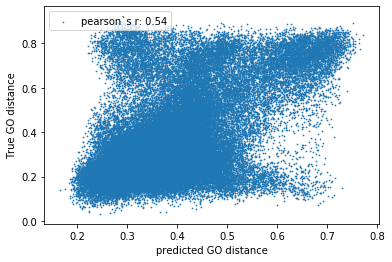

In [12]:
from utility.evaluator import model_evaluate
import numpy as np
from matplotlib import pyplot as plt
true = np.array(df_cold.value)
pred = np.array(df_cold.mu)
get_eval=model_evaluate(pred,true,test_params["prec_threshold"],df_cold)
print(get_eval)
plt.scatter(pred,true,s = 0.5, label = "pearson`s r: "+str(round(get_eval['cor'][0],2)))
plt.xlabel("predicted GO distance")
plt.ylabel("True GO distance")
plt.legend(loc='upper left')
plt.show()

# DeepSIBA example 3 : Screening

In this example a trained deepSIBA ensemble model will be used to identify chemical structures from the Chembl and the CMap datasets that affect similar biological processes to a query structure. 
Given a **query chemical structure and a cellular model**:

1. If a structural analogue to the query (ECFP4 similarity > 0.9) is present in the cell line's training set, the **CMap** and the **Chembl** datasets will be screened for chemical structures that affect similar BPs to the query.
2. If no structural analogue exists, the appropriate training set from the **CMap** dataset will be screened.

**NOTE** : Our trained deepSIBA ensembles allow query structures of up to 60 atoms. 

In [10]:
model_params = {
    "max_atoms" : int(60), "num_atom_features" : int(62), "max_degree" : int(5), "num_bond_features" : int(6),
    "graph_conv_width" : [128,128,128], "conv1d_filters" : int(128), "conv1d_size" : int(29), "dropout_encoder" : 0.25,
    "conv1d_filters_dist" : [128,128], "conv1d_size_dist" : [17,1], "dropout_dist" : 0.25, "pool_size" : int(4),
    "dense_size" : [256,128,128], "l2reg" : 0.01, "dist_thresh" : 0.2, "lr" : 0.001 
}

In [11]:
screening_params = {
    "query_smile" : "CC(C)(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2F)c(-c2ccnc(N)n2)s1", 
    "cell_line" : "a375", "split" : "5_fold_cv_split" ,"database" : ["Chembl","CMap"],
    "output_dir" : "C:/Users/user/Documents/deepSIBA/results/screening_test1" , "model_path" : "", 
    "atom_limit" : int(60), "N_models" : int(10),
    "name_pattern" : "siam_no_augment", "fold_id" : int(0),
    "screening_threshold" : 0.22
}

The screening_params dictionary contains the parameters required to screen a database with deepSIBA:

1. **query_smile** is the smile string of the chemical structure.
2. **cell_line** is the cellular model of choice out of **(a375,pc3,vcap,mcf7)** for which we have enough available data. Later a merged option will be added.
3. **split** is one of **(train_test_split,5_fold_cv_split,alldata,custom)**. The split selected defines the trained model ensemble that will be loaded. For the screening application the **alldata** split is suggested, where models are trained on the entirety of available data. If **custom** is selected the user must provide a path in **model_path** to load the custom trained models (up to models/ directory).
3. **database** is a list of the supported screening databases. So far only **Chembl** and **CMap** are supported.
4. **output_dir** full path to the desired output directory to write results. The Chembl screening is performed in parts due to the size of the database.
5. **atom_limit** the specified model_params of the trained models, when the split is not **custom** these should be 60.
6. **N_ensemble** is the number of total already trained models and at the same time the models included in the ensembled prediction.
7. **name_pattern** is the pattern of the name of files of models' saved weights. **For example** if the weights are saved in files with names such as **siam_no_augment_18.h5** the **pattern is siam_no_augment** .
8. **fold_id** is an integer, if split == 5_fold_cv_split the fold_id should be 0,1,2,3 or 4 (one less than the corresponding folder's name for this fold), in any other cases the fold_id is not used
9. **screening_threshold** only keep hits with predicted distance less than this threshold in the results.

In [12]:
from deepSIBA_screening import siba_screening
siba_screening(screening_params, model_params)

The selected chemical structure has at least one structural analogue in the training set, chembl and cmap will be screened
Finished screening for part 1/9 for the Chembl database
Finished screening for part 2/9 for the Chembl database
Finished screening for part 3/9 for the Chembl database
Finished screening for part 4/9 for the Chembl database


KeyboardInterrupt: 